# Model Fitting

* Preparation for modeling

* First model: Decision Tree

* Improvement: Random Forest

* Final model: Gradient Boosting

# Model comparation

Now I am going to talk about our model fitting process. I will start with the preparation for modeling, and move onto our first model, decision tree. Then based on the Decision Tree models, we improve it with Random Forest algorithm. And we see there are still some improvement we can do for it, so we choose to move to the Gradient Boosting algorithm. After that, I will talk about the model comparation part, to see why we decide to choose Gradient Boosting as our final model.

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

In [66]:
# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns
from beautifultable import BeautifulTable

In [3]:
# for feature engineering
import time 
import datetime
import scipy.stats

In [4]:
# for train and test data set split
from sklearn.model_selection import train_test_split

# for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for evaluation metric
# accuracy
from sklearn.metrics import accuracy_score
# Report
from sklearn.metrics import classification_report
# AUC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# for model comparision
from sklearn import metrics

In [5]:
# for decision tree model
from sklearn import tree

# for decision tree visualizaiton
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus

# for gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# for random search
from sklearn.ensemble import RandomForestClassifier

In [6]:
data = pd.read_csv("bid.csv")

In [7]:
# for all the missing value observation, drop it
bid = data.dropna()

In [9]:
# bidding time difference per user (bidder_id) 
bid = bid.sort_values(by=['time'])
bid['timediffs'] = bid.groupby('bidder_id')['time'].transform(pd.Series.diff)

# number of bids a user made per auction
bids_per_auction  = bid.groupby(['auction','bidder_id']).size()
bids_per_auction = bids_per_auction.to_frame()

# proportion of bots for each country
pbots_country = bid[bid['outcome'] == 1].groupby('country').size()/bid.groupby('country').size() 
pbots_country = pbots_country.fillna(0)
pbots_country = pbots_country.to_frame()

# proportion of bots per device
pbots_device = bid[bid['outcome'] == 1].groupby('device').size()/bid.groupby('device').size()
pbots_device = pbots_device.fillna(0)
pbots_device = pbots_device.to_frame()

# number of unique ip to number of bids ratio
ip_bids_ratio = bid.groupby('bidder_id')['ip'].nunique()/bid.groupby('bidder_id')['bid_id'].nunique()
ip_bids_ratio = ip_bids_ratio.to_frame()

# mean per auction url entropy for each user
# Input a pandas series 
def ent(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

auction_url_entropy = bid.groupby(['auction','bidder_id'])['url'].apply(ent)
auction_url_entropy = auction_url_entropy.groupby('bidder_id').mean().reset_index()

In [10]:
# merge the features back
bid = pd.merge(bid,bids_per_auction, on=['auction','bidder_id'],how='left')
bid = pd.merge(bid,pbots_country, on='country',how='left')
bid = pd.merge(bid,pbots_device, on='device',how='left')
bid = pd.merge(bid,ip_bids_ratio, on='bidder_id',how='left')
bid = pd.merge(bid,auction_url_entropy,on='bidder_id',how='left')
# set column names 
bid.columns = ['Unnamed: 0', 'bidder_id', 'payment_account', 'address', 'outcome',
       'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
       'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device', 
               'ip_bids_ratio','auction_url_entropy']

In [11]:
bids = pd.concat([bid.iloc[:,4],bid.iloc[:,-6:]],axis=1) 

## Preparation for Modeling

### Train-test split

In [33]:
bid_train, bid_test= train_test_split(bid, test_size=0.2)

### Resampling data

In [74]:
print(f"total bids made by robots in data set: {len(bid[bid['outcome'] == 1])}")
print(f"total bids made by human in data set:  {len(bid[bid['outcome'] == 0])}")
print(f"the ratio of bids made by robot vs. total bids in data set:  %.2f" % float(len(bid[bid['outcome'] == 1])/(len(bid[bid['outcome'] == 0])+len(bid[bid['outcome'] == 1]))))

total bids made by robots in data set: 412153
total bids made by human in data set:  2656370
the ratio of bids made by robot vs. total bids in data set:  0.13


These trainning data set has unbalanced number of robots and human:
* we might need to do resampling before training the model.
* for the evaluation metrices, we will foucus on AUC and precision vs. recall.

We choose to under sampling the training data.

In [14]:
bots_train = bid_train.loc[bid_train.outcome == 1]
human_train = bid_train.loc[bid_train.outcome == 0]
human_sample = human_train.sample(n=len(bots_train))
bid_train_balance = pd.concat([bots_train,human_sample])

### Separate lebal and features

In [15]:
y_train = bid_train_balance['outcome']
X_train = bid_train_balance.iloc[:,-5:]
y_test = bid_test['outcome']
X_test = bid_test.iloc[:,-5:]

Let's start with preparation:
First we just did the train and test dataset split, we according to the 80-20 rule.
Then we remember from the feature selection part, we detect our data set is really imbalanced, so we come up with two solutions, one is resampling the training dataset. Since we more focus on robots detection, which is the small fraction, it is only 13% of the whole dataset; we decided to use under sampling method to balance the training dataset.
After that, we just separate the label and features and ready for modeling.

## First Model : Decision Tree

In [172]:
clf = tree.DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(3,6),
    'max_leaf_nodes':range(10,15),
    'min_samples_split':range(2,6)
}

clf_cv = GridSearchCV(estimator=clf, 
                      param_grid=param_grid, 
                      cv=5)
clf_cv.fit(X_train, y_train)
print(clf_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 14, 'min_samples_split': 2}


How to decide range of hpyerparameters?

In [16]:
start_time = time.time()
kwargs_regularize = dict(criterion='gini',
                         max_depth = 5,
                         max_leaf_nodes=14, 
                         min_samples_split=2)
dt = tree.DecisionTreeClassifier(**kwargs_regularize)
dt.fit(X_train,y_train)

dt_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.212656021118164 seconds ---


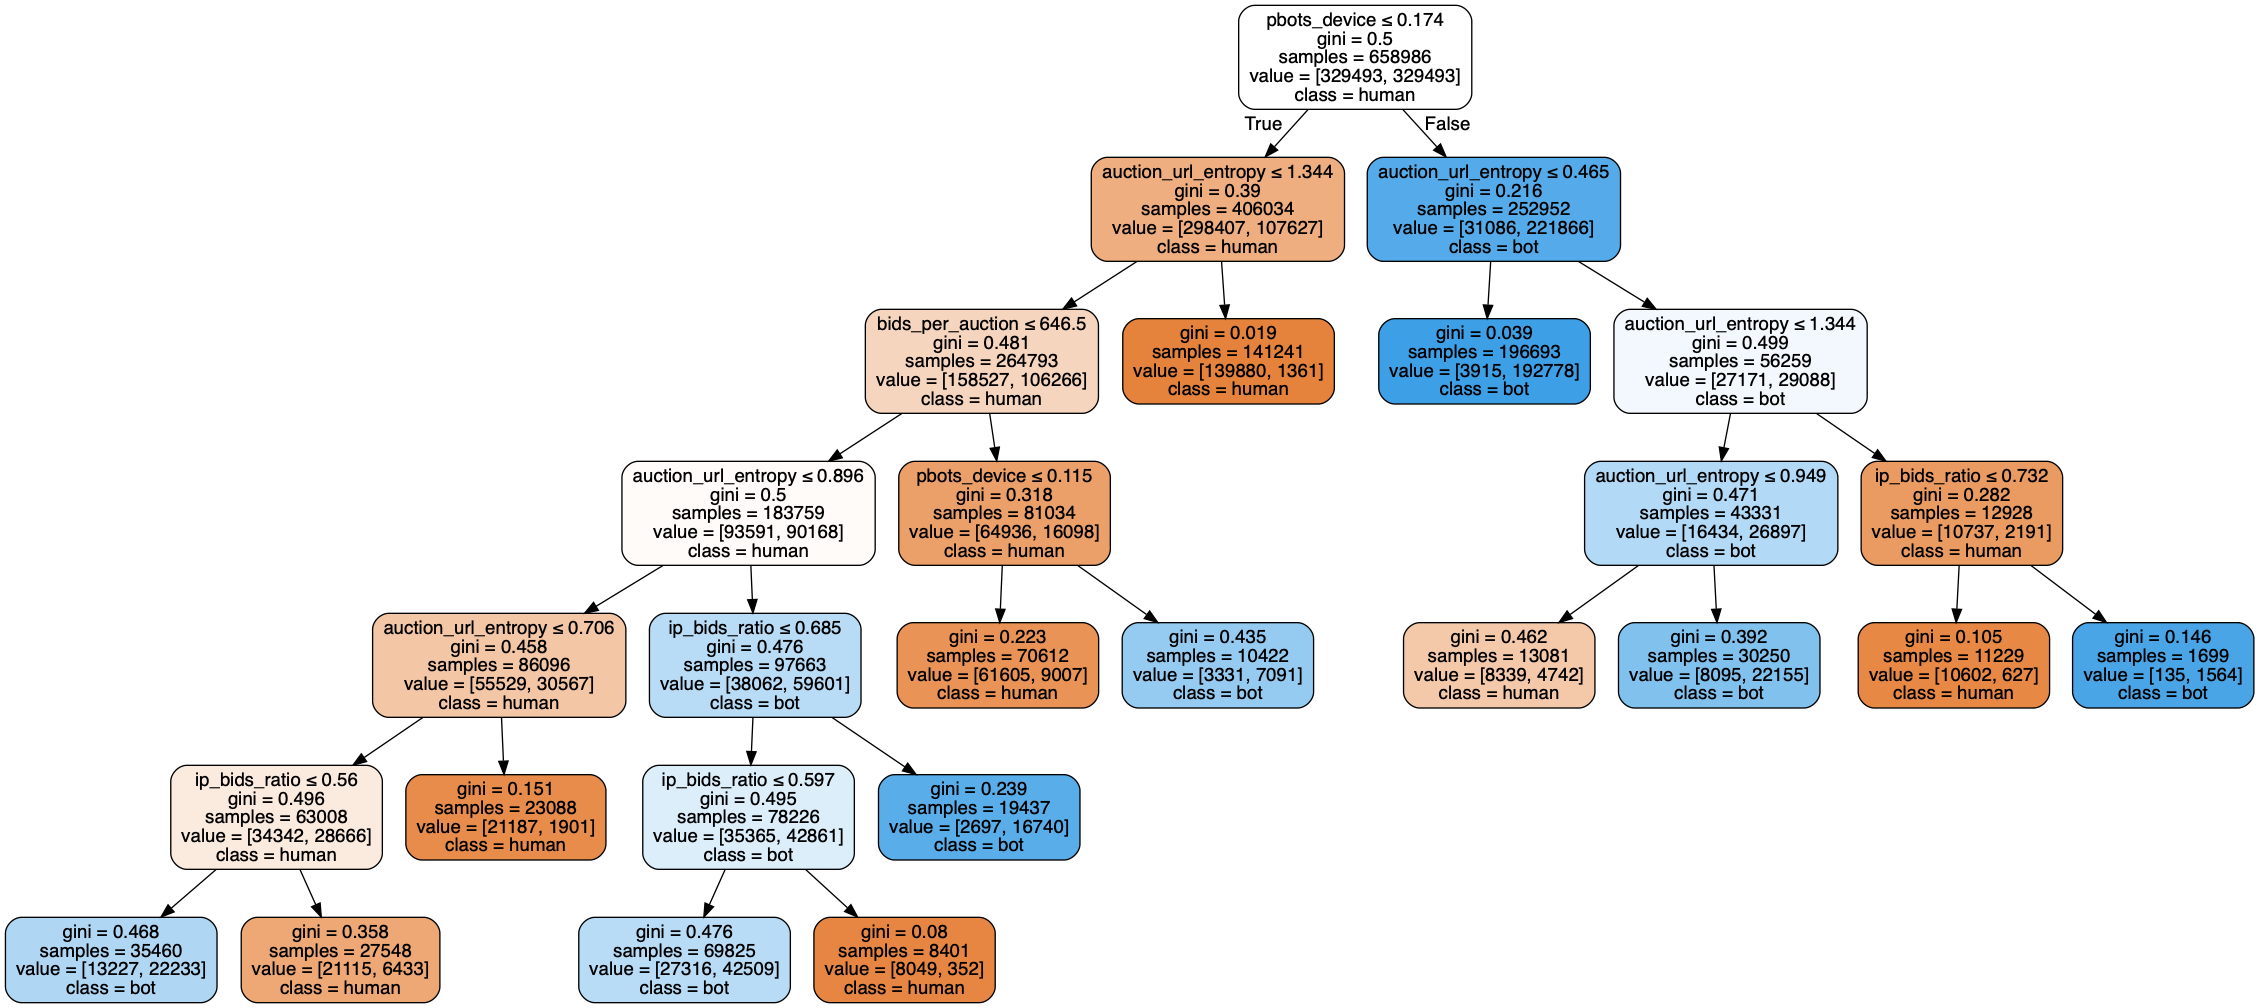

In [18]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, 
                         filled=True, rounded=True,
                     feature_names=X.columns.values,
                     class_names = ['human','bot'],
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

tree.png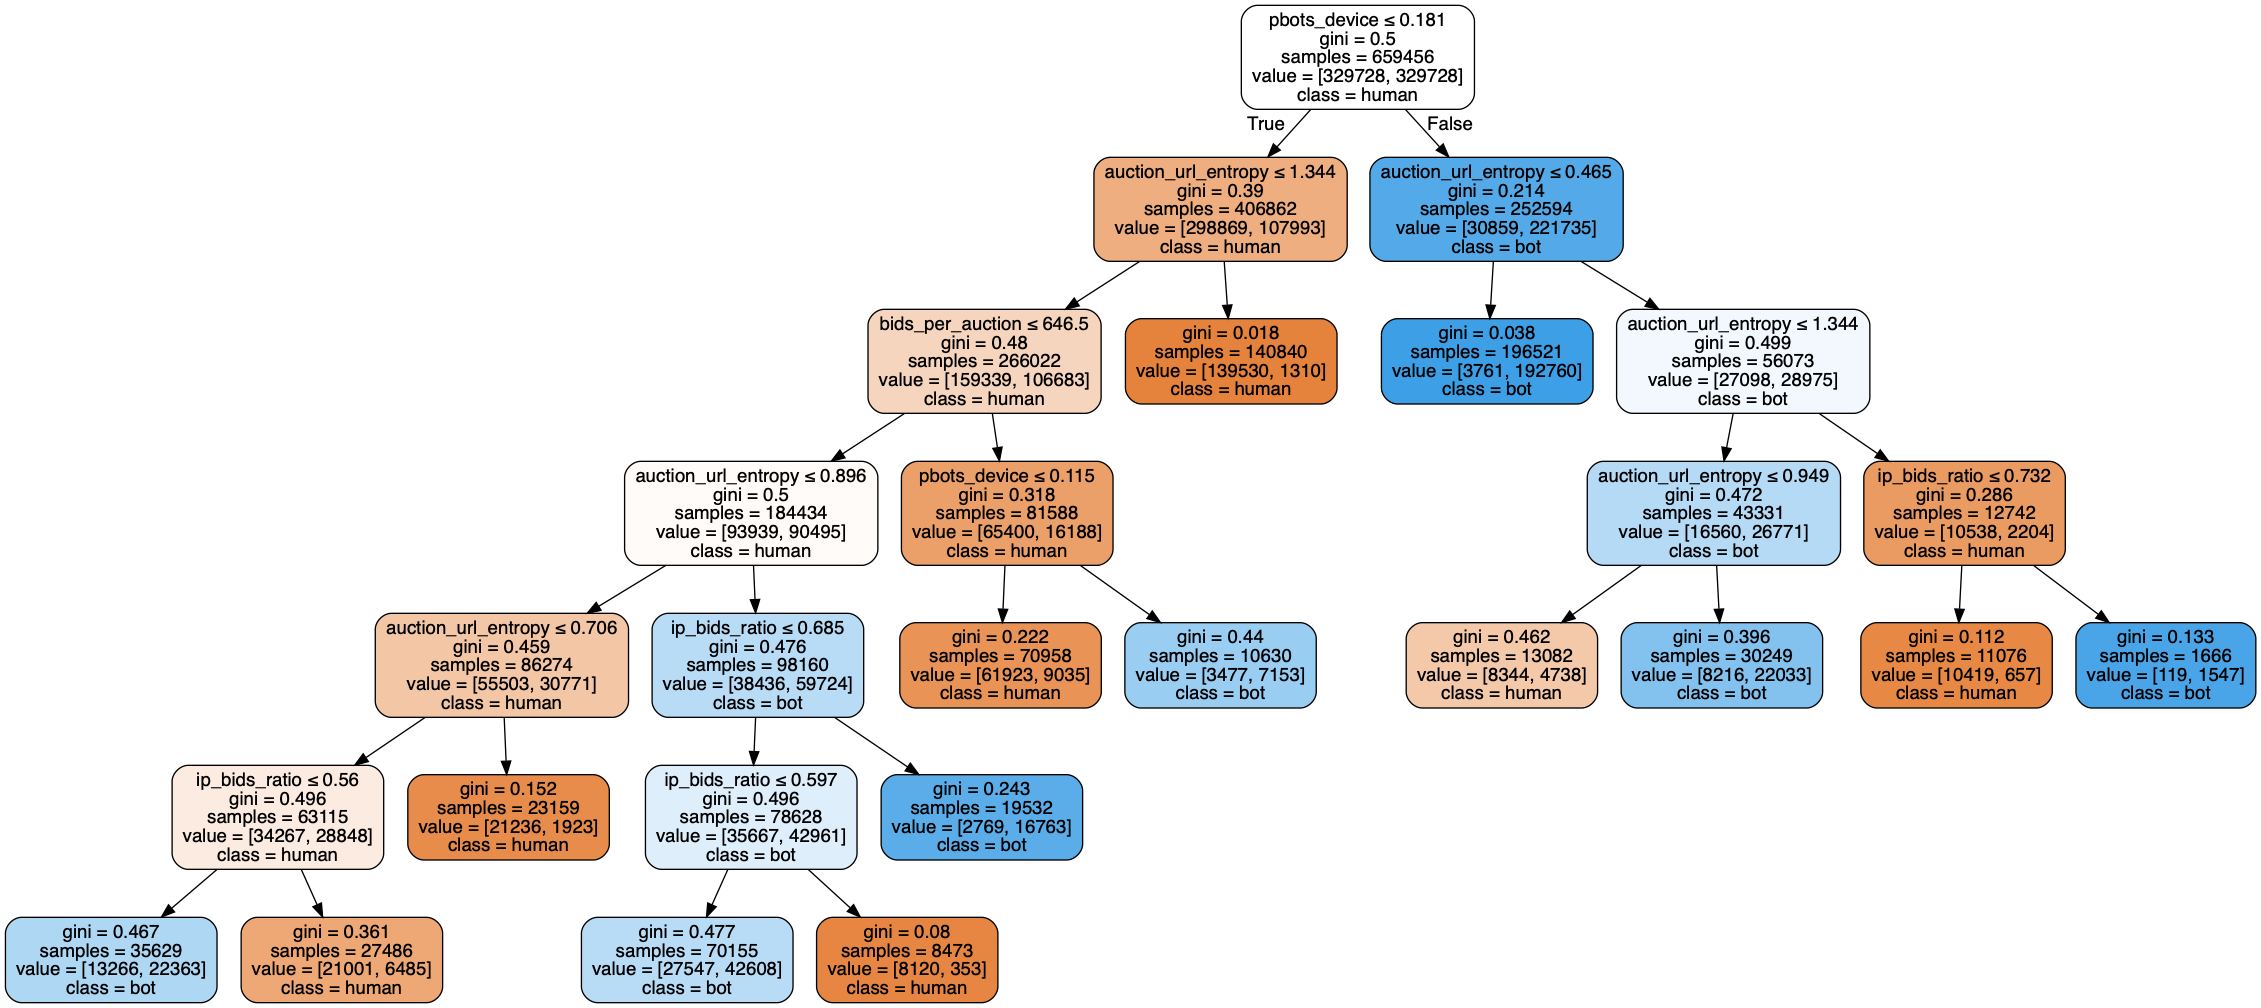

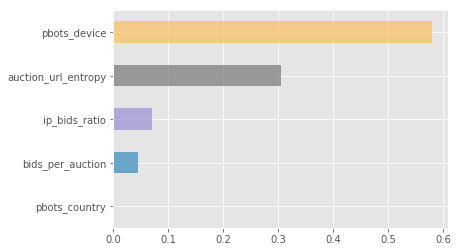

In [35]:
plt.style.use('ggplot')
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh',alpha=0.7)

dt_feature.png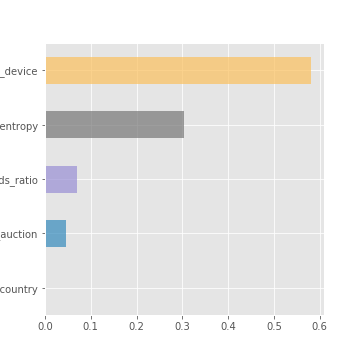

Let's look at our fist model decision tree. First, we use the grid search to find the best hyper-parameters of the decision tree, and fit a decision tree model with those hyper-parameters. As you can see, in this stage, we calculate the running time for model fitting, thus we could use it for the future model comparing. Here is our decision tree, and we also visulize the feature importance of our decision tree models. As you can see from here, our decision tree model is mostly based on the "proportion of bots per device", and there is no use of the "proportion of bots for each country". This won't a big deal until now, let's move on to the evaluation metric of our decision tree model.

### Evaluation Metric

#### Base model

In [40]:
# base model accuracy
print(f"base model accuracy: {2656370/(2656370+412153):.4f}")

base model accuracy: 0.8657


why base model accuary use this formula?

Before we check the evaluation metrics of decision tree model, let's first look at our accuracy of the base model. The accuracy of our base model is almost 87%. Then let's check the accuracy of our decision tree model.

In [60]:
# accuracy score
y_dt_pred = dt.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_dt_pred, y_test):.3f}")

Decision Tree Accuracy: 0.834


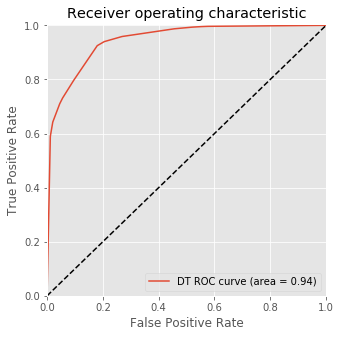

In [62]:
# Plot ROC in one graph
y_dt_score = dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, _dt = roc_curve(y_test, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(5,5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [61]:
print('Classification Report of Model 1 Decision Tree')
print(classification_report(y_test, y_dt_pred))

Classification Report of Model 1 Decision Tree
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90    531045
         1.0       0.44      0.92      0.60     82660

   micro avg       0.83      0.83      0.83    613705
   macro avg       0.72      0.87      0.75    613705
weighted avg       0.91      0.83      0.86    613705



The accuracy of our decision tree model is 83%, which is lower than the base model. so it is not good enough. since our dataset is imbalanced, the second solution we came up with is use the AUC to evaluate. Thus we can see from the AUC, it is much better.
Since our goal is to detect robots to help improve the user experience, we want to detect as many as robots, meanwhile lower the possible of mis-lebal a human user as robots. We will more focus on the recall and precison of robots detection. For decision tree model, the recall of robots detection is 87%, which is a good start, however, the precision for robots detection is only 54%, which means we will have a highly possiblity to mislebal some human user as robots. Thus we want to improve our model.

## Improvement: Random Forest

In [82]:
rf= RandomForestClassifier(n_estimators=50)
param_grid = { 
    'max_depth': range(3,6),
    'max_leaf_nodes' : range(8,12),
    'max_features':['sqrt','auto','log2']
}

rf_cv = GridSearchCV(estimator=rf, 
                      param_grid=param_grid, 
                      cv=5)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 11}


In [41]:
start_time = time.time()

rf= RandomForestClassifier(n_estimators=100,max_depth=5,
                           max_leaf_nodes=11,max_features='log2', 
                                bootstrap=True,oob_score=True)
rf.fit(X_train, y_train)

rf_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 74.12487816810608 seconds ---


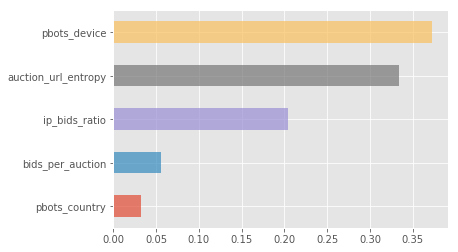

In [47]:
plt.style.use('ggplot')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh',alpha=0.7)

So we move on to Random Forest algorithm, which using the ensemble method to improve decision tree.

### Evaluation Metric

In [42]:
y_rf_pred = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_rf_pred, y_test):.3f}")

Decision Tree Accuracy: 0.924


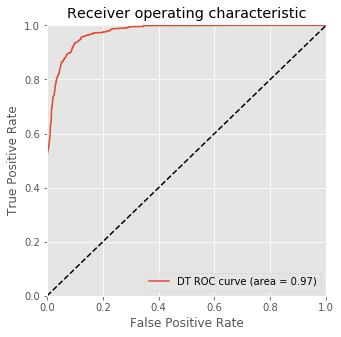

In [45]:
# Plot ROC in one graph
y_rf_score = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _rf = roc_curve(y_test, y_rf_score)
roc_rf_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5,5))
plt.plot(fpr_rf, tpr_rf, label='DT ROC curve (area = %0.2f)' % roc_rf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [43]:
print(classification_report(y_test,y_rf_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96    531045
         1.0       0.66      0.89      0.76     82660

   micro avg       0.92      0.92      0.92    613705
   macro avg       0.82      0.91      0.86    613705
weighted avg       0.94      0.92      0.93    613705



## Final Model: Gradient Boosting

In [66]:
gb = GradientBoostingClassifier(n_estimators=10)
param_grid = { 
    'max_depth': range(3,6),
    'max_leaf_nodes' : range(8,11)
}

gb_cv = GridSearchCV(estimator=gb, 
                      param_grid=param_grid, 
                      cv=5)
gb_cv.fit(X_train, y_train)
print(gb_cv.best_params_)

{'max_depth': 5, 'max_leaf_nodes': 9}


In [48]:
start_time = time.time()

gb = GradientBoostingClassifier(n_estimators=100,max_depth=5,max_features='sqrt',
                                 max_leaf_nodes=9)
gb.fit(X_train, y_train)

gb_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 66.43246173858643 seconds ---


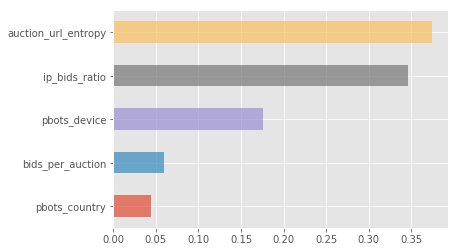

In [49]:
plt.style.use('ggplot')
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(5).plot(kind='barh',alpha=0.7)

### Evaluation Metrics

In [50]:
y_gb_pred = gb.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_gb_pred, y_test):.3f}")

Decision Tree Accuracy: 0.977


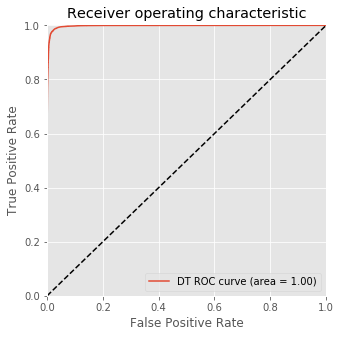

In [53]:
# Plot ROC in one graph
y_gb_score = gb.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _gb = roc_curve(y_test, y_gb_score)
roc_gb_auc = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(5,5))
plt.plot(fpr_gb, tpr_gb, label='DT ROC curve (area = %0.2f)' % roc_gb_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
print(classification_report(y_test,y_gb_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    531045
         1.0       0.86      0.98      0.92     82660

   micro avg       0.98      0.98      0.98    613705
   macro avg       0.93      0.98      0.95    613705
weighted avg       0.98      0.98      0.98    613705



## Model Comparation

In [63]:
dt_metrics = ['Decision Tree', metrics.accuracy_score(y_test,y_dt_pred),metrics.precision_score(y_test,y_dt_pred),
     metrics.recall_score(y_test,y_dt_pred),metrics.f1_score(y_test,y_dt_pred),
     metrics.roc_auc_score(y_test,y_dt_pred), dt_time]
rf_metrics = ['Random Forest', metrics.accuracy_score(y_test,y_rf_pred),metrics.precision_score(y_test,y_rf_pred),
     metrics.recall_score(y_test,y_rf_pred),metrics.f1_score(y_test,y_rf_pred),
     metrics.roc_auc_score(y_test,y_rf_pred), rf_time]
gb_metrics = ['Gradient Boosting', metrics.accuracy_score(y_test,y_gb_pred),metrics.precision_score(y_test,y_gb_pred),
     metrics.recall_score(y_test,y_gb_pred),metrics.f1_score(y_test,y_gb_pred),
     metrics.roc_auc_score(y_test,y_gb_pred), gb_time]

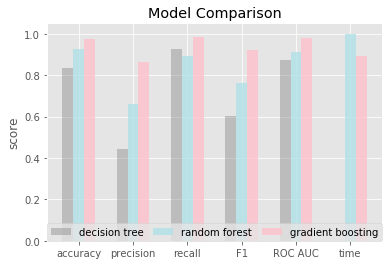

In [70]:
fig, ax = plt.subplots()
index = np.arange(6)
width = 0.2
b1 = plt.bar(index, dt_metrics[1:7], width, alpha=0.4, color='grey', label='decision tree')
b2 = plt.bar(index+width, rf_metrics[1:7], width, alpha=0.8, color='powderblue', label='random forest')
b3 = plt.bar(index+2*width, gb_metrics[1:7], width, alpha=0.8, color='pink', label='gradient boosting')
plt.title('Model Comparison')
plt.ylabel('score')
plt.xticks(index+width,('accuracy','precision','recall','F1','ROC AUC','time'))
plt.legend(loc=8,ncol=3, mode="expand", borderaxespad=0.)
plt.show()

In [69]:
min_time = min([dt_time,rf_time,gb_time])
max_time = max([dt_time,rf_time,gb_time])
dt_metrics[6] = (dt_time-min_time)/ (max_time - min_time)
rf_metrics[6] = (rf_time-min_time)/ (max_time - min_time)
gb_metrics[6] = (gb_time-min_time)/ (max_time - min_time)

In [67]:
table = BeautifulTable(max_width=110)
table.column_headers = ["Model", "Accuracy_score", "Precision_score", "Recall_Score","F1_score","ROC_AUC_score","Time"]
table.append_row(dt_metrics)
table.append_row(rf_metrics)
table.append_row(gb_metrics)
print(table)

+--------------------+-----------------+------------------+--------------+----------+----------------+--------+
|       Model        | Accuracy_score  | Precision_score  | Recall_Score | F1_score | ROC_AUC_score  |  Time  |
+--------------------+-----------------+------------------+--------------+----------+----------------+--------+
|   Decision Tree    |      0.834      |      0.445       |    0.925     |  0.601   |     0.873      | 1.213  |
+--------------------+-----------------+------------------+--------------+----------+----------------+--------+
|   Random Forest    |      0.924      |      0.663       |    0.893     |  0.761   |     0.911      | 74.125 |
+--------------------+-----------------+------------------+--------------+----------+----------------+--------+
| Gradient Boosting  |      0.977      |      0.862       |    0.985     |  0.919   |      0.98      | 66.432 |
+--------------------+-----------------+------------------+--------------+----------+----------------+--